## Imports

In [1]:
import tempfile
import os
import glob
from tqdm import tqdm

import tensorflow as tf
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, models

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Reading the Data 

In [39]:
directory = './trainfolders/'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=32, image_size=(40,
    40), shuffle=True, seed=42, validation_split=0.2, subset="training"
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.


In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=32, image_size=(40,
    40), shuffle=True, seed=42, validation_split=0.2, subset="validation"
)

Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [41]:
testdirectory = './testfolders/'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    testdirectory, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=32, image_size=(40,
    40), shuffle=True, seed=42,
)

Found 12630 files belonging to 43 classes.


In [42]:
class_names = train_ds.class_names
class_names

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '5',
 '6',
 '7',
 '8',
 '9']

In [43]:
# Download class names
# wget "https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv" -outfile "signnames.csv"
classes = pd.read_csv('signnames.csv')
myclass_names = {}
for i, row in classes.iterrows():
    myclass_names[str(row[0])] = row[1]

In [44]:
myclass_names

{'0': 'Speed limit (20km/h)',
 '1': 'Speed limit (30km/h)',
 '2': 'Speed limit (50km/h)',
 '3': 'Speed limit (60km/h)',
 '4': 'Speed limit (70km/h)',
 '5': 'Speed limit (80km/h)',
 '6': 'End of speed limit (80km/h)',
 '7': 'Speed limit (100km/h)',
 '8': 'Speed limit (120km/h)',
 '9': 'No passing',
 '10': 'No passing for vehicles over 3.5 metric tons',
 '11': 'Right-of-way at the next intersection',
 '12': 'Priority road',
 '13': 'Yield',
 '14': 'Stop',
 '15': 'No vechiles',
 '16': 'Vehicles over 3.5 metric tons prohibited',
 '17': 'No entry',
 '18': 'General caution',
 '19': 'Dangerous curve to the left',
 '20': 'Dangerous curve to the right',
 '21': 'Double curve',
 '22': 'Bumpy road',
 '23': 'Slippery road',
 '24': 'Road narrows on the right',
 '25': 'Road work',
 '26': 'Traffic signals',
 '27': 'Pedestrians',
 '28': 'Children crossing',
 '29': 'Bicycles crossing',
 '30': 'Beware of ice/snow',
 '31': 'Wild animals crossing',
 '32': 'End of all speed and passing limits',
 '33': 'Turn 

#### Manually Reading from File system

In [4]:
def readTrainTestImages(trainpath,testpath):
    trainImages = []
    testImages = []
    trainimgfiles = glob.glob(trainpath + '/*.png')
    testimgfiles = glob.glob(testpath + '/*.png')
    trainimgfiles = sorted(trainimgfiles, key=lambda x: int(x.split("\\")[1].split(".")[0]))
    testimgfiles = sorted(testimgfiles, key=lambda x: int(x.split("\\")[1].split(".")[0]))
    for i in tqdm(range(len(trainimgfiles))):
        # Read Images
#         print(trainimgfiles[i])
        img = mpimg.imread(trainimgfiles[i])   
        trainImages.append(img)        
    print('read ' + str(i) + " training images")   
    
    for i in tqdm(range(len(testimgfiles))):
        # Read Images
#         print(testimgfiles[i])
        img = mpimg.imread(testimgfiles[i])   
        testImages.append(img)        
    print(f'read {i} test images')
            
    
    trainImages = np.array(trainImages, dtype='float32')
    testImages = np.array(testImages, dtype='float32')
    
    trainlabels = pd.read_csv(trainpath + '/trainlabels.csv',index_col=False)
    testlabels = pd.read_csv(testpath + '/testlabels.csv',index_col=False)
    trainlabels.drop(trainlabels.columns[0], axis=1, inplace=True)
    testlabels.drop(testlabels.columns[0], axis=1, inplace=True)
    
    return trainImages, trainlabels, testImages, testlabels
#     return trainimgfiles, testimgfiles
    

In [5]:
trainpath = './train-pngs'
testpath = './test-pngs'
trainData, trainLabels, testData, testLabels = readTrainTestImages(trainpath,testpath)

  3%|█▍                                                       | 317/12630 [00:00<00:03, 3081.94it/s]

read 39208 training images


100%|███████████████████████████████████████████████████████| 12630/12630 [00:04<00:00, 3021.71it/s]


read 12629 test images


In [6]:
len(trainData),len(trainLabels), len(testData), len(testLabels)

(39209, 39209, 12630, 12630)

In [7]:
trainData.shape, trainLabels.shape

((39209, 40, 40, 3), (39209, 1))

In [8]:
trainLabels.head()

,Class
0,0
1,0
2,0
3,0
4,0


In [9]:
testLabels.head()

,Class
0,16
1,1
2,38
3,33
4,11


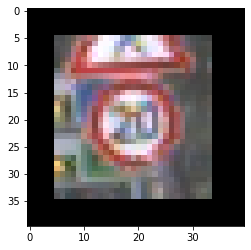

In [10]:
plt.imshow(trainData[0])

In [11]:
testLabels.iloc[42]['Class']

18

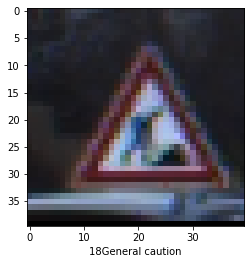

In [12]:
plt.xlabel(str(testLabels.iloc[42]['Class']) + str(class_names[str(testLabels.iloc[42]['Class'])]))
plt.imshow(testData[42])

### plot a few samples with labels

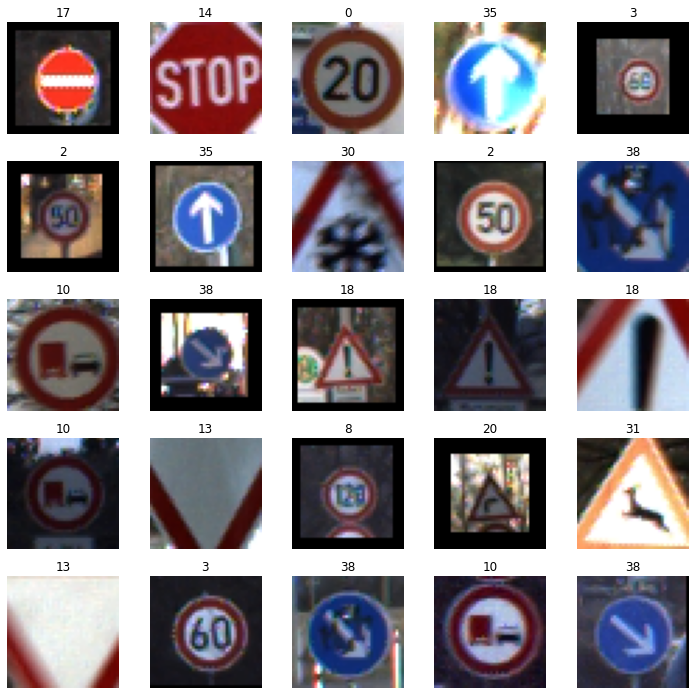

In [131]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.tight_layout()
        plt.title(class_names[labels[i]])
#         print(labels)
        plt.axis("off")

### Manual Read - Plots 

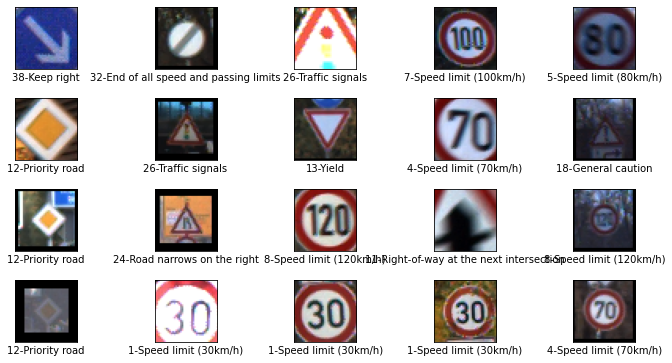

In [20]:
import random
plot = 1
plt.figure(figsize=(10,10))
for i in range(20):
    rand = random.randint(0,len(trainLabels))
    img = trainData[rand]
    label = trainLabels.iloc[rand]['Class']
    plt.subplot(8,5,plot)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(str(label) + "-" + str(myclass_names[str(label)]))
    plot += 1
plt.show()

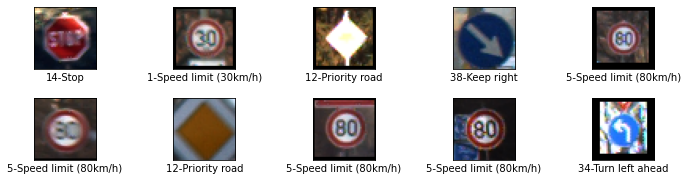

In [19]:
import random
plot = 1
plt.figure(figsize=(10,10))
for i in range(10):
    rand = random.randint(0,len(testLabels))
    img = testData[rand]
    label = testLabels.iloc[rand]['Class']
    plt.subplot(8,5,plot)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(str(label) + "-" + str(myclass_names[str(label)]))
    plot += 1
plt.show()

In [15]:
# myTrain = pd.DataFrame(trainData,columns=['Image'])

## GPU Setup

In [16]:
tf.__version__

'2.3.0'

In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [19]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Baseline CNN Model

In [36]:
IMG_SIZE=40
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.BatchNormalization(center=True, scale=False))
# model.add(layers.GaussianNoise(0.5))
model.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.BatchNormalization(center=True, scale=False))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization(center=True, scale=False))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(43))

In [37]:
initial_learning_rate = 0.01
epochs = 10
decay = initial_learning_rate / 100

adamOpt = tf.keras.optimizers.Adam(learning_rate=0.01)

def lr_time_based_decay(epoch):
    return initial_learning_rate * 1 / (1 + decay * epoch)

lrdecay = keras.callbacks.LearningRateScheduler(lr_time_based_decay,verbose=1)

early_stop=keras.callbacks.EarlyStopping(monitor='loss',patience=10)

In [38]:
# trainTensor = tf.random.shuffle(tf.convert_to_tensor(trainData),seed=42)
# trainLabelTensor = tf.random.shuffle(tf.convert_to_tensor(trainLabels),seed=42)

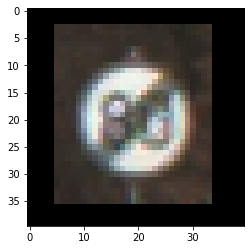

In [54]:
plt.imshow(trainData[104])

(39209, 40, 40, 3)

In [58]:
trainLabels.iloc[104]

Class    0
Name: 104, dtype: int64

In [59]:
class_names['0']

'Speed limit (20km/h)'

In [40]:
model.compile(optimizer=adamOpt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #
              metrics=['accuracy'])

history = model.fit(trainTensor, trainLabelTensor, epochs=150, validation_split=0.2,verbose=1,callbacks=[early_stop,lrdecay]) #early_stop, callbacks=[early_stop,lrdecay]

Epoch 1/150
981/981 [==============================] - 9s 9ms/step - loss: 4.1956 - accuracy: 0.2560 - val_loss: 2.7080 - val_accuracy: 0.3602
Epoch 2/150
981/981 [==============================] - 9s 9ms/step - loss: 2.8624 - accuracy: 0.3612 - val_loss: 2.4804 - val_accuracy: 0.3905
Epoch 3/150
981/981 [==============================] - 9s 9ms/step - loss: 2.3196 - accuracy: 0.4220 - val_loss: 1.9755 - val_accuracy: 0.4621
Epoch 4/150
981/981 [==============================] - 9s 9ms/step - loss: 2.0101 - accuracy: 0.4829 - val_loss: 11.2678 - val_accuracy: 0.5305
Epoch 5/150
981/981 [==============================] - 9s 9ms/step - loss: 1.8629 - accuracy: 0.5153 - val_loss: 7.9783 - val_accuracy: 0.5320
Epoch 6/150
981/981 [==============================] - 10s 10ms/step - loss: 1.6829 - accuracy: 0.5541 - val_loss: 1.3849 - val_accuracy: 0.6264
Epoch 7/150
981/981 [==============================] - 10s 10ms/step - loss: 1.7142 - accuracy: 0.5709 - val_loss: 2.1529 - val_accuracy: 0

## Baseline CNN #2

In [121]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 40, 40, 3)
(32,)


In [123]:
# AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=32)
val_ds = val_ds.cache().prefetch(buffer_size=32)

In [125]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [127]:
num_classes = 43
img_height=40
img_width=40


model = models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [128]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [129]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 40, 40, 16)        448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 64)         

In [130]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    verbose=1
)

Epoch 1/10
981/981 [==============================] - 76s 77ms/step - loss: 1.3765 - accuracy: 0.6196 - val_loss: 0.3810 - val_accuracy: 0.8926
Epoch 2/10
981/981 [==============================] - 14s 15ms/step - loss: 0.2697 - accuracy: 0.9223 - val_loss: 0.1912 - val_accuracy: 0.9445
Epoch 3/10
981/981 [==============================] - 14s 14ms/step - loss: 0.1376 - accuracy: 0.9593 - val_loss: 0.1329 - val_accuracy: 0.9617
Epoch 4/10
981/981 [==============================] - 15s 15ms/step - loss: 0.0794 - accuracy: 0.9765 - val_loss: 0.1031 - val_accuracy: 0.9712
Epoch 5/10
981/981 [==============================] - 15s 15ms/step - loss: 0.0579 - accuracy: 0.9827 - val_loss: 0.1513 - val_accuracy: 0.9575
Epoch 6/10
981/981 [==============================] - 15s 15ms/step - loss: 0.0569 - accuracy: 0.9821 - val_loss: 0.1088 - val_accuracy: 0.9714
Epoch 7/10
981/981 [==============================] - 14s 14ms/step - loss: 0.0349 - accuracy: 0.9894 - val_loss: 0.0706 - val_accuracy:

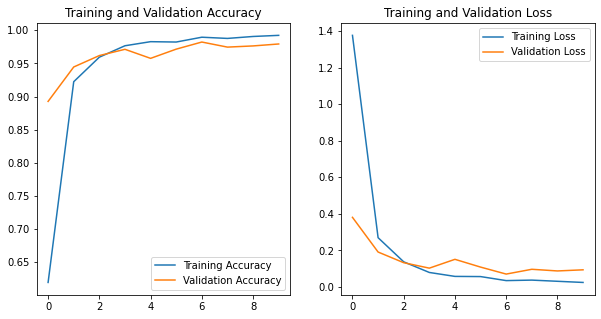

In [135]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [138]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

395/395 [==============================] - 9s 23ms/step - loss: 0.6011 - accuracy: 0.8909


## Experiments

### CNN with Gaussian Noise

In [3]:
testLayer = layers.GaussianNoise(5, input_shape=(-1,40,40,-1),dtype=tf.float32) #50
testLayer

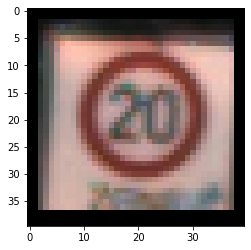

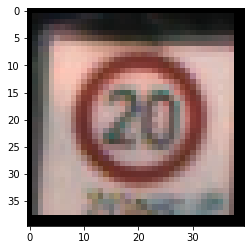

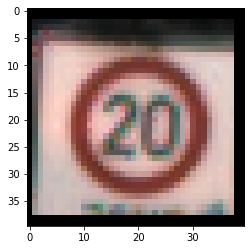

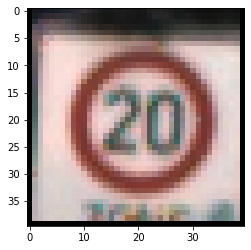

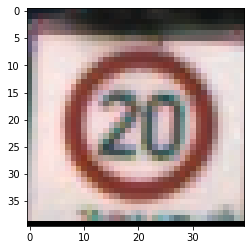

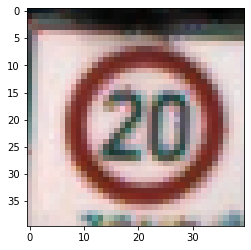

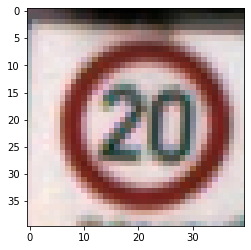

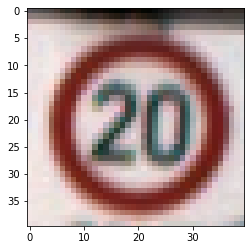

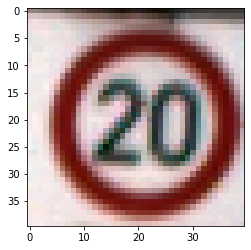

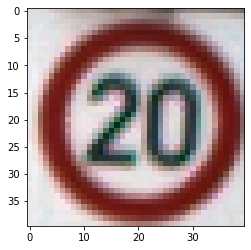

In [6]:
for index in range(100,110):
    noise_img = testLayer(trainData[index]) #add_salt_pepper_noise(trainData[index])
    plt.imshow(noise_img)
    plt.show()
#     path = './noisydata/gaussian25/' + str(index) + '.png'
#     tf.keras.preprocessing.image.save_img(path, noise_img)
#     mpimg.imsave(path, noise_img,format='PNG')

In [7]:
import matplotlib.image as mpimg
from tqdm import tqdm

for index in tqdm(range(len(testData))):
    path = './noisydata/gaussian5/' +  str(testLabels.iloc[index]['Class']) + "/"
    filename = path + str(index) + '.png'
        
    if not os.path.exists(path):
        os.mkdir(path)

    noise_img = testLayer(trainData[index])
    tf.keras.preprocessing.image.save_img(filename, noise_img)

100%|████████████████████████████████████████████████████████| 12630/12630 [00:14<00:00, 877.38it/s]


In [261]:
testop = testLayer(train_ds.take(1))

In [262]:
testoplist = next(iter(testop))


In [ ]:
for i in range(32):
    plt.imshow(testoplist[0][i].numpy().astype("uint8"))
    plt.show()

In [139]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 40, 40, 3)
(32,)


In [142]:
num_classes = 43
img_height=40
img_width=40


gaussmodel = models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.GaussianNoise(0.5),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.GaussianNoise(0.5),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [143]:
gaussmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [144]:
gaussmodel.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 40, 40, 3)         0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 40, 40, 16)        448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 20, 20, 16)        0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 10, 10, 32)       

In [145]:
epochs=10
gausshistory = gaussmodel.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    verbose=1
)

Epoch 1/10
981/981 [==============================] - 16s 16ms/step - loss: 2.6492 - accuracy: 0.2771 - val_loss: 2.5078 - val_accuracy: 0.3511
Epoch 2/10
981/981 [==============================] - 16s 16ms/step - loss: 1.4839 - accuracy: 0.5567 - val_loss: 1.2324 - val_accuracy: 0.6525
Epoch 3/10
981/981 [==============================] - 16s 16ms/step - loss: 1.1142 - accuracy: 0.6582 - val_loss: 0.9266 - val_accuracy: 0.7272
Epoch 4/10
981/981 [==============================] - 16s 17ms/step - loss: 0.9564 - accuracy: 0.7010 - val_loss: 0.8377 - val_accuracy: 0.7457
Epoch 5/10
981/981 [==============================] - 16s 16ms/step - loss: 0.8658 - accuracy: 0.7277 - val_loss: 0.6919 - val_accuracy: 0.7954
Epoch 6/10
981/981 [==============================] - 16s 16ms/step - loss: 0.7923 - accuracy: 0.7530 - val_loss: 0.6803 - val_accuracy: 0.8024
Epoch 7/10
981/981 [==============================] - 16s 16ms/step - loss: 0.7565 - accuracy: 0.7579 - val_loss: 0.6333 - val_accuracy:

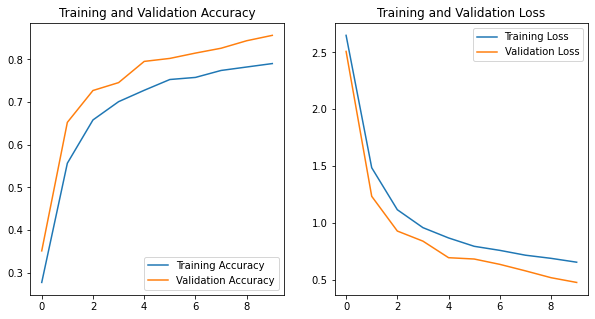

In [220]:
acc = gausshistory.history['accuracy']
val_acc = gausshistory.history['val_accuracy']

loss = gausshistory.history['loss']
val_loss = gausshistory.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [221]:
test_loss, test_acc = gaussmodel.evaluate(test_ds, verbose=1)

395/395 [==============================] - 10s 24ms/step - loss: 0.9666 - accuracy: 0.7283


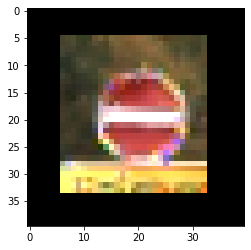

In [249]:
get = next(iter(test_ds))

plt.imshow(get[0][0].numpy().astype("uint8"))

### CNN with Gaussian Noise #2

In [264]:
num_classes = 43
img_height=40
img_width=40


gaussmodel2 = models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.GaussianNoise(50),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [265]:
gaussmodel2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [266]:
gaussmodel2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 40, 40, 3)         0         
_________________________________________________________________
gaussian_noise_17 (GaussianN (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 40, 40, 16)        448       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 10, 10, 64)       

In [268]:
epochs=10
gausshistory2 = gaussmodel2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    verbose=1
)

Epoch 1/10
981/981 [==============================] - 15s 15ms/step - loss: 3.7060 - accuracy: 0.0555 - val_loss: 3.7058 - val_accuracy: 0.0547
Epoch 2/10
981/981 [==============================] - 15s 16ms/step - loss: 3.4924 - accuracy: 0.0544 - val_loss: 3.6854 - val_accuracy: 0.0547
Epoch 3/10
981/981 [==============================] - 15s 15ms/step - loss: 3.4885 - accuracy: 0.0548 - val_loss: 3.6682 - val_accuracy: 0.0547
Epoch 4/10
981/981 [==============================] - 15s 15ms/step - loss: 3.4878 - accuracy: 0.0548 - val_loss: 3.6485 - val_accuracy: 0.0547
Epoch 5/10
981/981 [==============================] - 15s 15ms/step - loss: 3.4870 - accuracy: 0.0570 - val_loss: 3.6343 - val_accuracy: 0.0547
Epoch 6/10
981/981 [==============================] - 15s 15ms/step - loss: 3.4884 - accuracy: 0.0572 - val_loss: 3.6137 - val_accuracy: 0.0547
Epoch 7/10
981/981 [==============================] - 15s 15ms/step - loss: 3.4867 - accuracy: 0.0583 - val_loss: 3.5954 - val_accuracy:

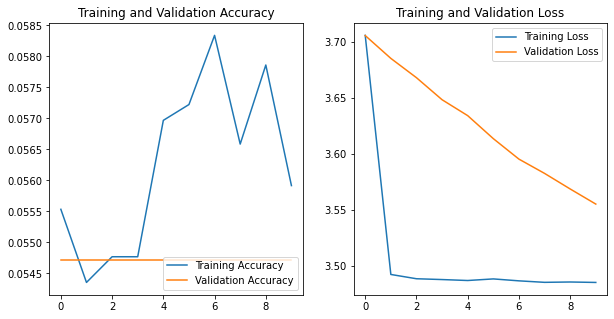

In [269]:
acc = gausshistory2.history['accuracy']
val_acc = gausshistory2.history['val_accuracy']

loss = gausshistory2.history['loss']
val_loss = gausshistory2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [270]:
test_loss, test_acc = gaussmodel2.evaluate(test_ds, verbose=1)

395/395 [==============================] - 9s 23ms/step - loss: 3.5313 - accuracy: 0.0594 4s - l - ETA: 0s - loss: 3.530


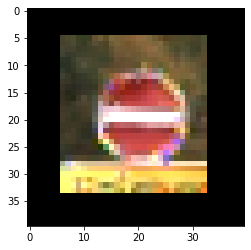

In [249]:
get = next(iter(test_ds))

plt.imshow(get[0][0].numpy().astype("uint8"))

### CNN with Salt and Pepper Noise at Inference time

In [ ]:
testdirectory = './testfolders/'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    testdirectory, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=32, image_size=(40,
    40), shuffle=True, seed=42,
)

In [35]:
num_classes = 43
img_height=40
img_width=40


snpmodel = models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [36]:
snpmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
snpmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 40, 40, 3)         0         
_________________________________________________________________
gaussian_noise_4 (GaussianNo (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        1

In [45]:
epochs=10
snphistory = snpmodel.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    verbose=1
)

Epoch 1/10
 92/981 [=>............................] - ETA: 5:58 - loss: 6.4666 - accuracy: 0.0530

KeyboardInterrupt: 

In [ ]:
acc = snphistory.history['accuracy']
val_acc = snphistory.history['val_accuracy']

loss = snphistory.history['loss']
val_loss = snphistory.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_loss, test_acc = snpmodel.evaluate(test_ds, verbose=1)

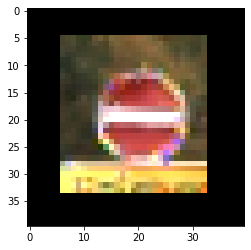

In [249]:
get = next(iter(test_ds))

plt.imshow(get[0][0].numpy().astype("uint8"))

#### Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(valid_generator, valid_generator.samples //valid_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))
print('Classification Report')
target_names = class_names
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

# END